# Курсовой проект

**Задача**

На основании имеющихся данных о клиентах банка требуется построить модель для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1($\beta$ = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной **(0 или 1, а НЕ вероятность)** для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатываться от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном файле (ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 6 дней после окончания последнего урока.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.Смысловое описание признаков
Home Ownership HO - домовладение
Annual Income AI - годовой доход
Years in current job YCJ - количество лет на текущем месте работы
Tax Liens TL - налоговые обременения
Number of Open Accounts NOA - количество открытых счетов
Years of Credit History YCH - количество лет кредитной истории
Maximum Open Credit MOC - наибольший открытый кредит
Number of Credit Problems NCP - количество проблем с кредитом
Months since last delinquent MSLD - количество месяцев с последней просрочки платежа
Bankruptcies B - банкротства
Purpose P - цель кредита
Term T - срок кредита
Current Loan Amount CLA - текущая сумма кредита
Current Credit Balance CCB - текущий кредитный баланс
Monthly Debt MD - ежемесячный долг
Credit Score CS - кредитный рейтинг
Credit Default CD - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Смысловое описание признаков**
- Home Ownership HO - домовладение
- Annual Income AI - годовой доход
- Years in current job YCJ - количество лет на текущем месте работы
- Tax Liens TL - налоговые обременения
- Number of Open Accounts NOA - количество открытых счетов
- Years of Credit History YCH - количество лет кредитной истории
- Maximum Open Credit MOC - наибольший открытый кредит
- Number of Credit Problems NCP - количество проблем с кредитом
- Months since last delinquent MSLD - количество месяцев с последней просрочки платежа
- Bankruptcies B - банкротства
- Purpose P - цель кредита
- Term T - срок кредита
- Current Loan Amount CLA - текущая сумма кредита
- Current Credit Balance CCB - текущий кредитный баланс
- Monthly Debt MD - ежемесячный долг
- Credit Score CS - кредитный рейтинг
- Credit Default CD - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [634]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import catboost as catb
from sklearn.metrics import r2_score, f1_score, precision_score, recall_score, classification_report

# 1 Чтение данных

In [635]:
train_data = pd.read_csv("course_project_train.csv")
test_data = pd.read_csv("course_project_test.csv")
X_train = train_data.drop("Credit Default", axis = 1)
X_test = test_data
y_train = train_data["Credit Default"]
y_test = test_data

In [636]:
X_train

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN


In [637]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

# 2 Анализ признаков

Построим корреляционную матрицу, для примерного представления о наличии связи признаков между собой.

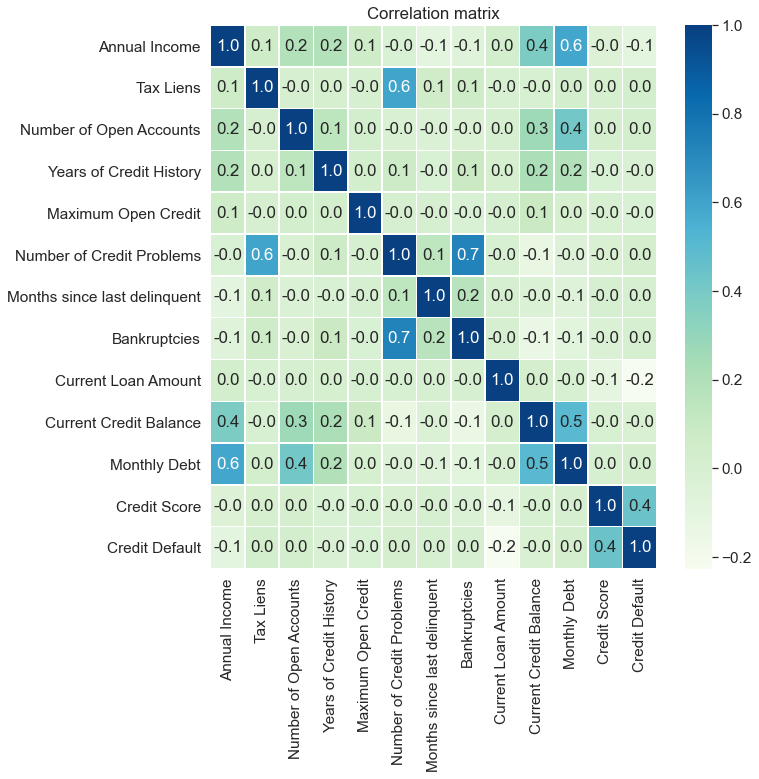

In [638]:
corr = train_data.corr()
plt.figure(figsize = (10, 10))
sns.set(font_scale=1.4)
sns.heatmap(train_data.corr(), annot=True, fmt='.1f', linewidths=.5, cmap='GnBu')
plt.title('Correlation matrix')
plt.show()

## 2.1 Анализ количественных признаков

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd3a2c76860>,
      dtype=object)

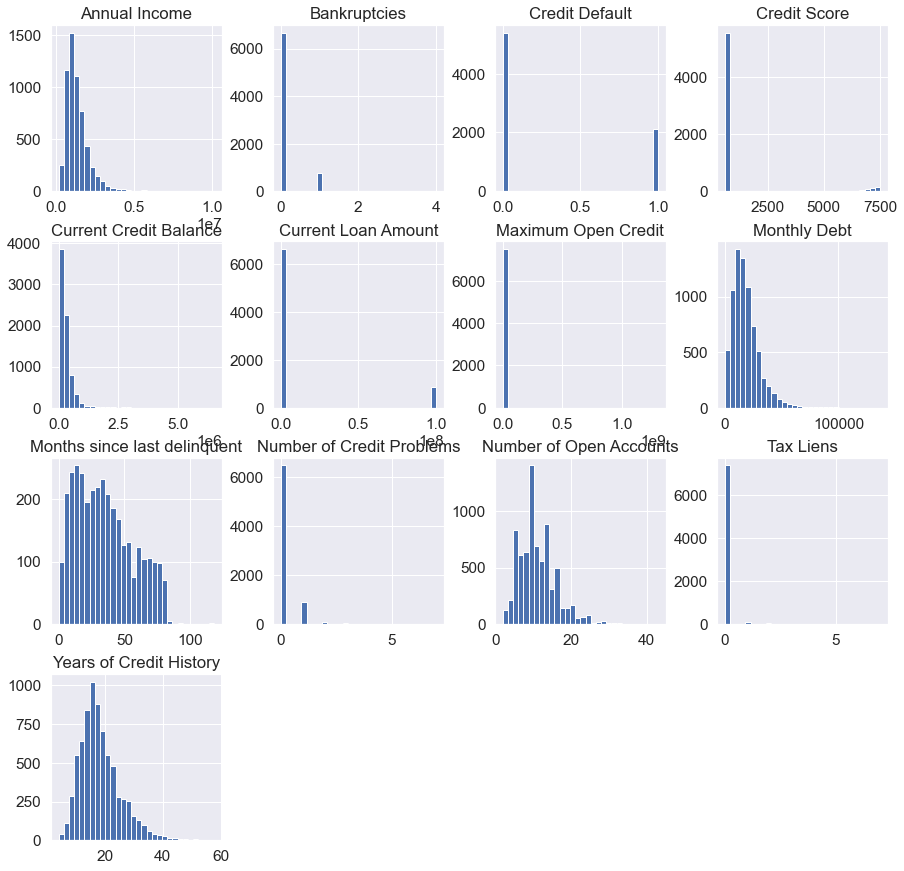

In [639]:
numeric_features = train_data.select_dtypes(exclude='object')
numeric_features = pd.DataFrame(numeric_features)
numeric_features.hist(figsize=(15, 15), bins = 30)

- Annual Income - непрерывный признак, распределение похоже на логнормальное, явных выбросов нет. Есть пропуски
- Bankruptcies - дискретный признак. Есть пропуски
- Credit Default - диксретный признак, целевая переменная, наблюдается дисбаланс между классами
- Credit Score - непрерывный признак, явные выбросы. Есть пропуски
- Current Credit Balance - непрерывая величина, распределение похоже на логнормальное, возможно есть нули
- Current Loan Amount - непрерывный признак, явные выбросы
- Maximum Open Credit - непрерывный признак, явные выбросы и возможно нули
- Monthly Debt - непрерывный признак, логнормальное распределение
- Months Since Last Delinquent - дискретный признак, выбросов нет. Много пропусков
- Number of Credit Problem - дискретный признак, выбросов нет
- Number of Open Accounts - дискретный признак, выбросов нет
- Tax Liens - дискретный признак, выбросов нет
- Years of Credit History - непрерывная величина, выбросов нет

## 2.2 Анализ категориальных признаков

In [640]:
test_feature = ["Home Ownership", "Years in current job", "Purpose", "Term"]
for feat in test_feature:
    print(feat)
    print(X_train[feat].isna().sum())
    print(X_train[feat].value_counts())
    print('***')

Home Ownership
0
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
***
Years in current job
371
10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
***
Purpose
0
debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
***
Term
0
Short Term    5556
Long Term     1944
Name: Term, dtype: int64
***


- Home Ownership - есть выбросы, нет пропусков
- Years in current job - нет выбросов, есть пропуски
- Purpose - нет выбросов, нет пропусков
- Term - нет выбросов, нет пропусков

## 2.3 Анализ выбросов

**Найденные признаки с выбросами:**
- Credit Score
- Current Loan Amount
- Maximum Open Credit
- Current Credit Balance
- Monthly Debt
- Home Ownership

In [641]:
def show_feature_outliers(df, feature_name):
    plt.figure(figsize = (12,4))
    
    plt.subplot(1,2,1)
    plt.boxplot(df.loc[df[feature_name].notna(),feature_name])
    
    plt.subplot(1,2,2)
    sns.distplot(df.loc[df[feature_name].notna(),feature_name])

### 2.3.1 Credit Score

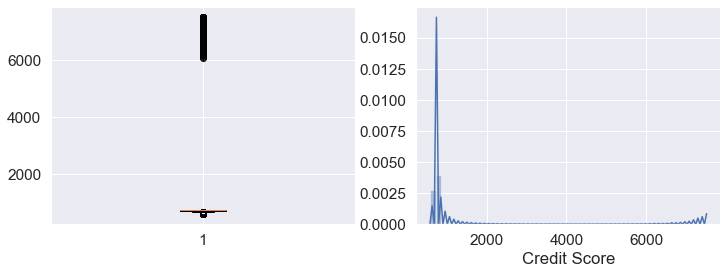

In [642]:
show_feature_outliers(X_train, 'Credit Score')

In [643]:
X_train.loc[X_train["Credit Score"] > 1000, "Credit Score"].value_counts()

7400.0    15
7300.0    13
7330.0    13
7170.0    12
7370.0    12
          ..
6830.0     1
6910.0     1
6450.0     1
6610.0     1
6170.0     1
Name: Credit Score, Length: 110, dtype: int64

Кажется, что все значения Credit Score больше 1000 просто домножены на 10, разделим их.

In [644]:
X_train.loc[X_train["Credit Score"] > 1000, "Credit Score"] = X_train.loc[X["Credit Score"] > 1000, "Credit Score"]/10

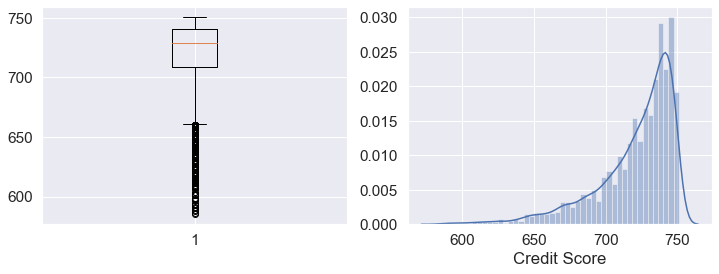

In [645]:
show_feature_outliers(X_train, 'Credit Score')

Выбросов нет, логнормальное распределение.

### 2.3.2 Current Loan Amount

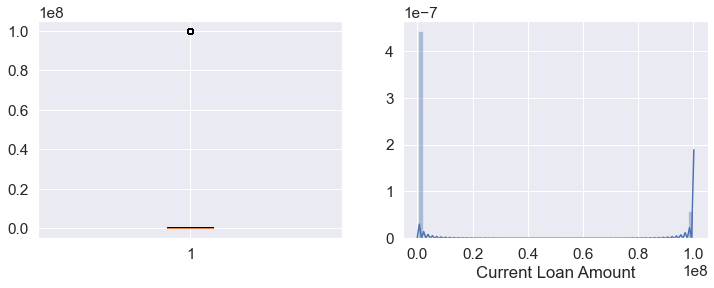

In [646]:
show_feature_outliers(X_train, 'Current Loan Amount')

In [647]:
X_train.loc[X_train["Current Loan Amount"] > 1000000, "Current Loan Amount"].value_counts()

99999999.0    870
Name: Current Loan Amount, dtype: int64

Очевидно, что все 870 знаечений больше 1 млн записаны как 99999999, необходимо получать эти значения, далее воспользуемся для этого регрессией, а сейчас заменим их на NaN.

In [648]:
X_train.loc[X_train["Current Loan Amount"] > 1000000, "Current Loan Amount"] = np.NaN

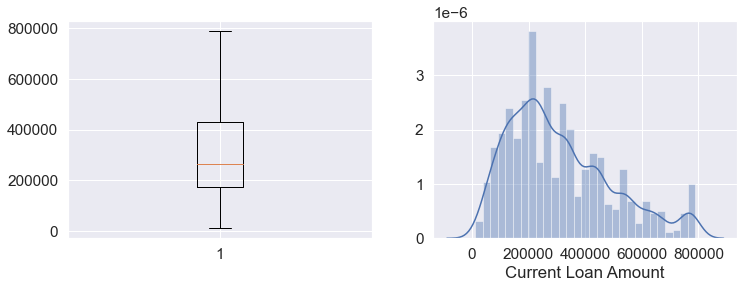

In [649]:
show_feature_outliers(X_train, 'Current Loan Amount')

### 2.3.3 Maximum Open Credit

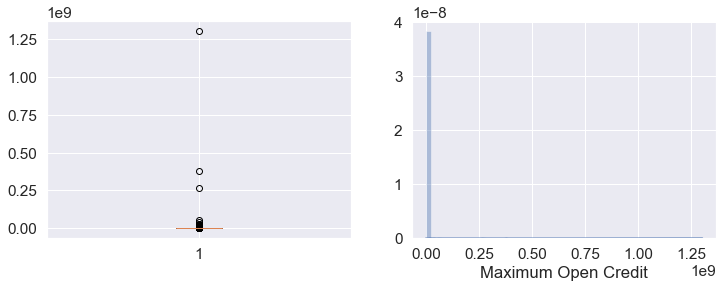

In [650]:
show_feature_outliers(X_train, 'Maximum Open Credit')

In [651]:
X_train.loc[X_train["Maximum Open Credit"] == 0, "Maximum Open Credit"]

8       0.0
91      0.0
196     0.0
294     0.0
309     0.0
       ... 
6593    0.0
6851    0.0
7014    0.0
7124    0.0
7233    0.0
Name: Maximum Open Credit, Length: 65, dtype: float64

In [652]:
X_train.loc[X_train["Maximum Open Credit"] > 10000000, "Maximum Open Credit"]

44      3.800523e+08
354     1.476048e+07
617     1.304726e+09
1476    1.042866e+07
1879    1.270144e+07
2023    5.756256e+07
2468    1.634591e+07
2617    2.655129e+08
2763    4.092389e+07
3170    1.868381e+07
4072    1.389707e+07
4745    1.160386e+07
4769    2.634333e+07
4840    1.020160e+07
5523    2.137243e+07
5731    1.928043e+07
5950    1.151346e+07
6744    1.030907e+07
7026    2.640700e+07
Name: Maximum Open Credit, dtype: float64

Есть суммы, которые слишком велики, более 10 млн, а также присутствуют нулевые значения. Из корреляционной матрицы, приведенный выше видно, что Maximum Open Credit имеет незначительную связ с признаком Current Credit Balance, проанализируем их взаимное распределение.

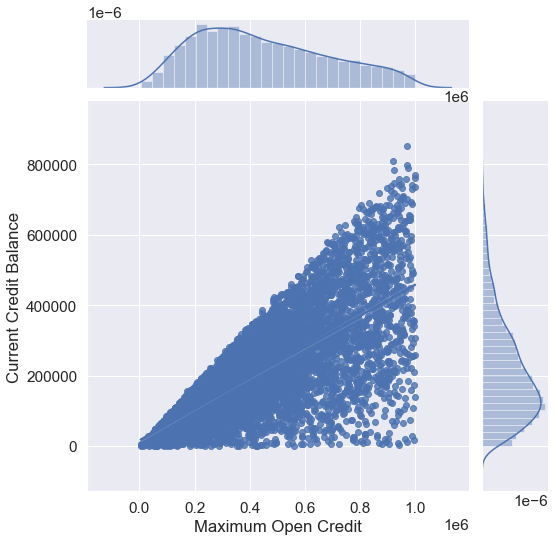

In [653]:
def show_joinplot(df, feature1, feature2):
    grid = sns.jointplot(df[feature1], df[feature2], kind='reg')
    grid.fig.set_figwidth(8)
    grid.fig.set_figheight(8)
    plt.show()
    
show_joinplot(X_train.loc[(X_train["Maximum Open Credit"] < 1000000) & (X_train["Maximum Open Credit"] != 0)], "Maximum Open Credit", "Current Credit Balance")

Видно, что присутствует некоторая связь между признаками, в среднем по линии тренда можно сказать, что Maximum Open Credit в 3 раза больше соответстующего ему Current Credit Balance, заменим найденные выбросы исходя из этого соображения.

In [654]:
X_train.loc[(X_train["Maximum Open Credit"] > 10000000) | (X_train["Maximum Open Credit"] == 0), "Maximum Open Credit"] = \
X_train.loc[(X_train["Maximum Open Credit"] > 10000000) | (X_train["Maximum Open Credit"] == 0), "Current Credit Balance"]*3

Итак, стало значительно лучше, но выбросы по прежнему остаются, особенно нулевые значения, заменим остальные значения медианой по признаку.

In [655]:
X_train.loc[(X_train["Maximum Open Credit"] > 10000000) | (X_train["Maximum Open Credit"] == 0), "Maximum Open Credit"] = \
X_train.loc[(X_train["Maximum Open Credit"] < 10000000) | (X_train["Maximum Open Credit"] != 0), "Maximum Open Credit"].median()

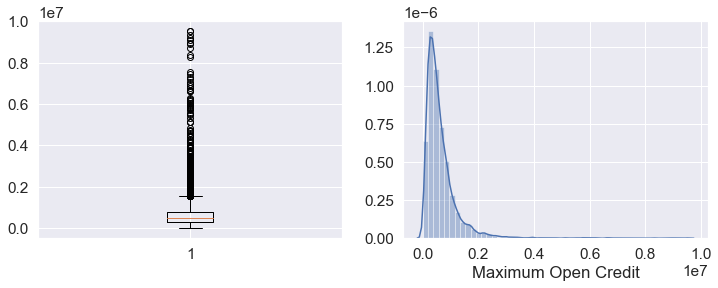

In [656]:
show_feature_outliers(X_train, 'Maximum Open Credit')

### 2.3.4 Current Credit Balance

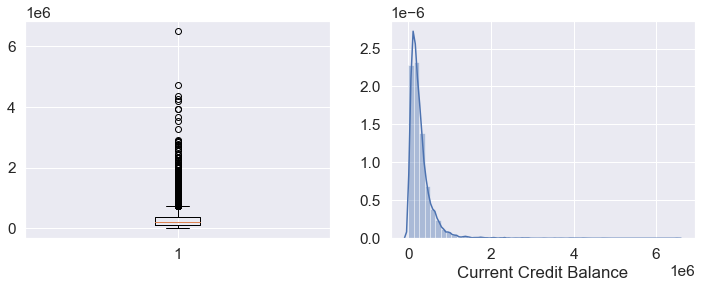

In [657]:
show_feature_outliers(X_train, 'Current Credit Balance')

In [658]:
X_train.loc[(X_train["Current Credit Balance"] == 0) , "Current Credit Balance"].shape

(53,)

Достаточно много нулей, заменим их в соответствии с описанной выше зависимостью.

In [659]:
X_train.loc[(X_train["Current Credit Balance"] == 0), "Current Credit Balance"] = \
X_train.loc[(X_train["Current Credit Balance"] == 0), "Maximum Open Credit"] / 3

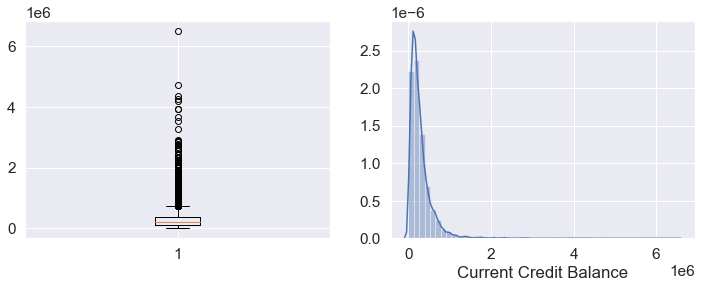

In [660]:
show_feature_outliers(X_train, 'Current Credit Balance')

### 2.3.5 Home Ownership

In [661]:
X_train['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

Очевидно, что Have Mortgage и Home Mortgage это одно и то же, произведем замену.

In [662]:
X_train.loc[X_train['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'

## 2.4 Заполнение пропусков

**Найденные признаки с пропусками:**
- Annual Income
- Bankruptcies
- Credit Score
- Months since last delinquent
- Years in current job
- Current Loan Amount

In [663]:
features = ['Annual Income','Bankruptcies','Credit Score','Months since last delinquent','Years in current job','Current Loan Amount']
for f in features:
    print(f)
    print(X_train[f].isna().sum())
    print('***')

Annual Income
1557
***
Bankruptcies
14
***
Credit Score
1957
***
Months since last delinquent
4081
***
Years in current job
371
***
Current Loan Amount
870
***


Удалим из обработки признак Months since last delinquent, поскольку он существует практически только для половины значений.
Years in current job и Bankruptcies заполним медианными значениями.
Annual Income, Credit Score и Current Loan Amount заполним с помощью регрессии.

### 2.4.1 Months since last delinquent

In [664]:
X_train.drop(['Months since last delinquent'], axis=1, inplace=True)

### 2.4.2 Years in current job

In [665]:
X_train['Years in current job']

0             NaN
1       10+ years
2         8 years
3         6 years
4         8 years
          ...    
7495     < 1 year
7496       1 year
7497      6 years
7498          NaN
7499      4 years
Name: Years in current job, Length: 7500, dtype: object

In [666]:
X_train.loc[X_train['Years in current job'] == '10+ years', 'Years in current job'] = 10
X_train.loc[X_train['Years in current job'] == '9 years', 'Years in current job'] = 9
X_train.loc[X_train['Years in current job'] == '8 years', 'Years in current job'] = 8
X_train.loc[X_train['Years in current job'] == '7 years', 'Years in current job'] = 7
X_train.loc[X_train['Years in current job'] == '6 years', 'Years in current job'] = 6
X_train.loc[X_train['Years in current job'] == '5 years', 'Years in current job'] = 5
X_train.loc[X_train['Years in current job'] == '4 years', 'Years in current job'] = 4
X_train.loc[X_train['Years in current job'] == '3 years', 'Years in current job'] = 3
X_train.loc[X_train['Years in current job'] == '2 years', 'Years in current job'] = 2
X_train.loc[X_train['Years in current job'] == '1 years', 'Years in current job'] = 1
X_train.loc[X_train['Years in current job'] == '1 year', 'Years in current job'] = 1
X_train.loc[X_train['Years in current job'] == '< 1 year', 'Years in current job'] = 0

In [667]:
X_train['Years in current job'] = X_train['Years in current job'].astype('float64')

In [668]:
X_train['Years in current job'].median()

6.0

In [669]:
X_train['Years in current job'].fillna(X_train['Years in current job'].median(), inplace=True)

### 2.4.3 Bankruptcies

In [670]:
X_train['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [671]:
X_train['Bankruptcies'].fillna(X_train['Bankruptcies'].median(), inplace=True)

### 2.4.4 Создание модели для заполнения пропущенных значений

In [672]:
def fillna_fit_model(target):
    
    data = X_train.copy()
    
    cat_feats = list(data.columns[data.dtypes==object])
    for cat_feat in cat_feats:
        data[cat_feat] = pd.Categorical(data[cat_feat])
    
    print(cat_feats)
    # удаление наблюдений с пропусками
    nan_index = data.loc[data[target].isna(), [target]].index
    data = data.drop(index=nan_index)
    
    X = data.drop([target], axis=1)
    y = data[target]
    
    X_train2, X_valid, y_train2, y_valid = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=11)
    
    model = catb.CatBoostRegressor(cat_features = cat_feats,                               
                                   n_estimators=200, 
                                   max_depth=3,
                                   silent=True, 
                                   random_state=42)
    
    model.fit(X_train2, y_train2)
    

    
    y_train_pred = model.predict(X_train2)
    y_valid_pred = model.predict(X_valid)
    print(target, 'r2_train:',r2_score(y_train2,y_train_pred).round(4))
    print(target, 'r2_valid:',r2_score(y_valid,y_valid_pred).round(4))
    return model

In [673]:
target = 'Credit Score'
model = fillna_fit_model(target)
notna_index = X_train.loc[X_train[target].notna(), [target]].index
X = X_train.drop(index=notna_index).drop([target], axis=1)
X_train.loc[X_train[target].isna(), target] = model.predict(X)

['Home Ownership', 'Purpose', 'Term']
Credit Score r2_train: 0.4579
Credit Score r2_valid: 0.3108


In [674]:
target = 'Annual Income'
model = fillna_fit_model(target)
notna_index = X_train.loc[X_train[target].notna(), [target]].index
X = X_train.drop(index=notna_index).drop([target], axis=1)
X_train.loc[X_train[target].isna(), target] = model.predict(X)

['Home Ownership', 'Purpose', 'Term']
Annual Income r2_train: 0.5578
Annual Income r2_valid: 0.4658


In [675]:
target = 'Current Loan Amount'
model = fillna_fit_model(target)
notna_index = X_train.loc[X_train[target].notna(), [target]].index
X = X_train.drop(index=notna_index).drop([target], axis=1)
X_train.loc[X_train[target].isna(), target] = model.predict(X)

['Home Ownership', 'Purpose', 'Term']
Current Loan Amount r2_train: 0.6062
Current Loan Amount r2_valid: 0.5358


In [676]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Home Ownership             7500 non-null   object 
 1   Annual Income              7500 non-null   float64
 2   Years in current job       7500 non-null   float64
 3   Tax Liens                  7500 non-null   float64
 4   Number of Open Accounts    7500 non-null   float64
 5   Years of Credit History    7500 non-null   float64
 6   Maximum Open Credit        7500 non-null   float64
 7   Number of Credit Problems  7500 non-null   float64
 8   Bankruptcies               7500 non-null   float64
 9   Purpose                    7500 non-null   object 
 10  Term                       7500 non-null   object 
 11  Current Loan Amount        7500 non-null   float64
 12  Current Credit Balance     7500 non-null   float64
 13  Monthly Debt               7500 non-null   float

Все пропуски заполнены, выбросы и ноли устранены. Объединим все произведенные манипуляции в один класс для последующей обработки и трейнового, и тестового датасетов.

# 3 Очистка признаков

Построим класс, который будет обучаться на трейновой выборке, и потом изменять тестовую выборку только по той информации, которую получил на первом этапе. класс объединяет в себе все манипуляции, выполненные ранее, они сохранены только для понимания хода анализа данных.

In [677]:
class FeatureImputer:
    
    def __init__(self):

        self.MOC_median = None
        self.YCJ_median = None
        self.B_median = None
        self.CS_model = None
        self.AI_model = None
        self.CLA_model = None
        
    
    def fit_fill_nan(self, X, target, n_estimators, max_depth):

        data = X.copy()

        cat_feats = list(data.columns[data.dtypes==object])
        for cat_feat in cat_feats:
            data[cat_feat] = pd.Categorical(data[cat_feat])

        index_nan = data.loc[data[target].isna(), [target]].index
        data = data.drop(index=index_nan)

        X_t = data.drop([target, 'Months since last delinquent'], axis=1)
        y_t = data[target]

        X_train_t, X_valid_t, y_train_t, y_valid_t = train_test_split(X_t, y_t, shuffle=True, test_size=0.25, random_state=11)

        model = catb.CatBoostRegressor(cat_features = cat_feats,                               
                                       n_estimators=n_estimators, 
                                       max_depth=max_depth,
                                       silent=True, 
                                       random_state=42)
        model.fit(X_train_t, y_train_t)

        y_train_pred = model.predict(X_train_t)
        y_valid_pred = model.predict(X_valid_t)

        print(target, 'r2_train:',r2_score(y_train_t,y_train_pred).round(4))
        print(target, 'r2_valid:',r2_score(y_valid_t,y_valid_pred).round(4))
        return model
    
    def fit(self, X):

        self.MOC_median = X.loc[(X["Maximum Open Credit"] < 10000000) | (X["Maximum Open Credit"] != 0),\
                                "Maximum Open Credit"].median()
        
        X.loc[X['Years in current job'] == '10+ years', 'Years in current job'] = 10
        X.loc[X['Years in current job'] == '9 years', 'Years in current job'] = 9
        X.loc[X['Years in current job'] == '8 years', 'Years in current job'] = 8
        X.loc[X['Years in current job'] == '7 years', 'Years in current job'] = 7
        X.loc[X['Years in current job'] == '6 years', 'Years in current job'] = 6
        X.loc[X['Years in current job'] == '5 years', 'Years in current job'] = 5
        X.loc[X['Years in current job'] == '4 years', 'Years in current job'] = 4
        X.loc[X['Years in current job'] == '3 years', 'Years in current job'] = 3
        X.loc[X['Years in current job'] == '2 years', 'Years in current job'] = 2
        X.loc[X['Years in current job'] == '1 years', 'Years in current job'] = 1
        X.loc[X['Years in current job'] == '1 year', 'Years in current job'] = 1
        X.loc[X['Years in current job'] == '< 1 year', 'Years in current job'] = 0
        
        X['Years in current job'] = X['Years in current job'].astype('float64')
        
        self.YCJ_median = X['Years in current job'].median()
        
        self.B_median = X['Bankruptcies'].median()
        
        
        X.loc[X["Credit Score"] > 1000, "Credit Score"] = X.loc[X["Credit Score"] > 1000, "Credit Score"]/10
        
        X.loc[X["Current Loan Amount"] > 1000000, "Current Loan Amount"] = np.NaN
        
        X.loc[(X["Maximum Open Credit"] > 10000000) | (X["Maximum Open Credit"] == 0), "Maximum Open Credit"] = \
        X.loc[(X["Maximum Open Credit"] > 10000000) | (X["Maximum Open Credit"] == 0), "Current Credit Balance"]*3
        
        X.loc[(X["Maximum Open Credit"] > 10000000) | (X["Maximum Open Credit"] == 0), "Maximum Open Credit"] = self.MOC_median
        
        X.loc[(X["Current Credit Balance"] == 0), "Current Credit Balance"] = \
        X.loc[(X["Current Credit Balance"] == 0), "Maximum Open Credit"] / 3
        
        X.loc[X['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
        
        X.loc[X['Years in current job'] == '10+ years', 'Years in current job'] = 10
        X.loc[X['Years in current job'] == '9 years', 'Years in current job'] = 9
        X.loc[X['Years in current job'] == '8 years', 'Years in current job'] = 8
        X.loc[X['Years in current job'] == '7 years', 'Years in current job'] = 7
        X.loc[X['Years in current job'] == '6 years', 'Years in current job'] = 6
        X.loc[X['Years in current job'] == '5 years', 'Years in current job'] = 5
        X.loc[X['Years in current job'] == '4 years', 'Years in current job'] = 4
        X.loc[X['Years in current job'] == '3 years', 'Years in current job'] = 3
        X.loc[X['Years in current job'] == '2 years', 'Years in current job'] = 2
        X.loc[X['Years in current job'] == '1 years', 'Years in current job'] = 1
        X.loc[X['Years in current job'] == '1 year', 'Years in current job'] = 1
        X.loc[X['Years in current job'] == '< 1 year', 'Years in current job'] = 0
        
        X['Years in current job'] = X['Years in current job'].astype('float64')
        
        X['Years in current job'].fillna(self.YCJ_median, inplace=True)
        
        X['Bankruptcies'].fillna(self.B_median, inplace=True)
        
        
        self.CS_model = self.fit_fill_nan(X, "Credit Score", 100, 3)
        self.AI_model = self.fit_fill_nan(X, "Annual Income", 100, 3)
        self.CLA_model = self.fit_fill_nan(X, "Current Loan Amount", 100, 3)
    
    def transform(self, X):
        
        X.loc[X["Credit Score"] > 1000, "Credit Score"] = X.loc[X["Credit Score"] > 1000, "Credit Score"]/10
        
        X.loc[X["Current Loan Amount"] > 1000000, "Current Loan Amount"] = np.NaN
        
        X.loc[(X["Maximum Open Credit"] > 10000000) | (X["Maximum Open Credit"] == 0), "Maximum Open Credit"] = \
        X.loc[(X["Maximum Open Credit"] > 10000000) | (X["Maximum Open Credit"] == 0), "Current Credit Balance"]*3
        
        X.loc[(X["Maximum Open Credit"] > 10000000) | (X["Maximum Open Credit"] == 0), "Maximum Open Credit"] = self.MOC_median
        
        X.loc[(X["Current Credit Balance"] == 0), "Current Credit Balance"] = \
        X.loc[(X["Current Credit Balance"] == 0), "Maximum Open Credit"] / 3
        
        X.loc[X['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
        
        X.drop(['Months since last delinquent'], axis=1, inplace=True)
        
        X.loc[X['Years in current job'] == '10+ years', 'Years in current job'] = 10
        X.loc[X['Years in current job'] == '9 years', 'Years in current job'] = 9
        X.loc[X['Years in current job'] == '8 years', 'Years in current job'] = 8
        X.loc[X['Years in current job'] == '7 years', 'Years in current job'] = 7
        X.loc[X['Years in current job'] == '6 years', 'Years in current job'] = 6
        X.loc[X['Years in current job'] == '5 years', 'Years in current job'] = 5
        X.loc[X['Years in current job'] == '4 years', 'Years in current job'] = 4
        X.loc[X['Years in current job'] == '3 years', 'Years in current job'] = 3
        X.loc[X['Years in current job'] == '2 years', 'Years in current job'] = 2
        X.loc[X['Years in current job'] == '1 years', 'Years in current job'] = 1
        X.loc[X['Years in current job'] == '1 year', 'Years in current job'] = 1
        X.loc[X['Years in current job'] == '< 1 year', 'Years in current job'] = 0
        
        X['Years in current job'] = X['Years in current job'].astype('float64')
        
        X['Years in current job'].fillna(self.YCJ_median, inplace=True)
        
        X['Bankruptcies'].fillna(self.B_median, inplace=True)
        
        cat_feats = list(X.columns[X.dtypes==object])
        for cat_feat in cat_feats:
            X[cat_feat] = pd.Categorical(X[cat_feat])
        
        notna_index = X.loc[X['Credit Score'].notna(), ['Credit Score']].index
        X_nan = X.drop(index=notna_index).drop(['Credit Score'], axis=1)
        X.loc[X['Credit Score'].isna(), 'Credit Score'] = self.CS_model.predict(X_nan)
        
        notna_index = X.loc[X['Annual Income'].notna(), ['Annual Income']].index
        X_nan = X.drop(index=notna_index).drop(['Annual Income'], axis=1)
        X.loc[X['Annual Income'].isna(), 'Annual Income'] = self.AI_model.predict(X_nan)
        
        notna_index = X.loc[X['Current Loan Amount'].notna(), ['Current Loan Amount']].index
        X_nan = X.drop(index=notna_index).drop(['Current Loan Amount'], axis=1)
        X.loc[X['Current Loan Amount'].isna(), 'Current Loan Amount'] = self.CLA_model.predict(X_nan)
        
        return X

In [678]:
train_data = pd.read_csv("course_project_train.csv")
test_data = pd.read_csv("course_project_test.csv")
X_train = train_data.drop("Credit Default", axis = 1)
X_test = test_data
y_train = train_data["Credit Default"]

Заново парсим данные и передаем их в класс, на трейновой выборке класс обучается, строятся регрессионнные модели, затем единым способом изменяется и трейновая, и тестовая выборки.

In [679]:
imputer = FeatureImputer()

imputer.fit(X_train)

X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Credit Score r2_train: 0.438
Credit Score r2_valid: 0.348
Annual Income r2_train: 0.5534
Annual Income r2_valid: 0.4661
Current Loan Amount r2_train: 0.5463
Current Loan Amount r2_valid: 0.5042


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Проверяем распределения признаков после всей произведенной обработки, убеждаемся что все распределения в порядке как на train, так и на test.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd378def1d0>,
      dtype=object)

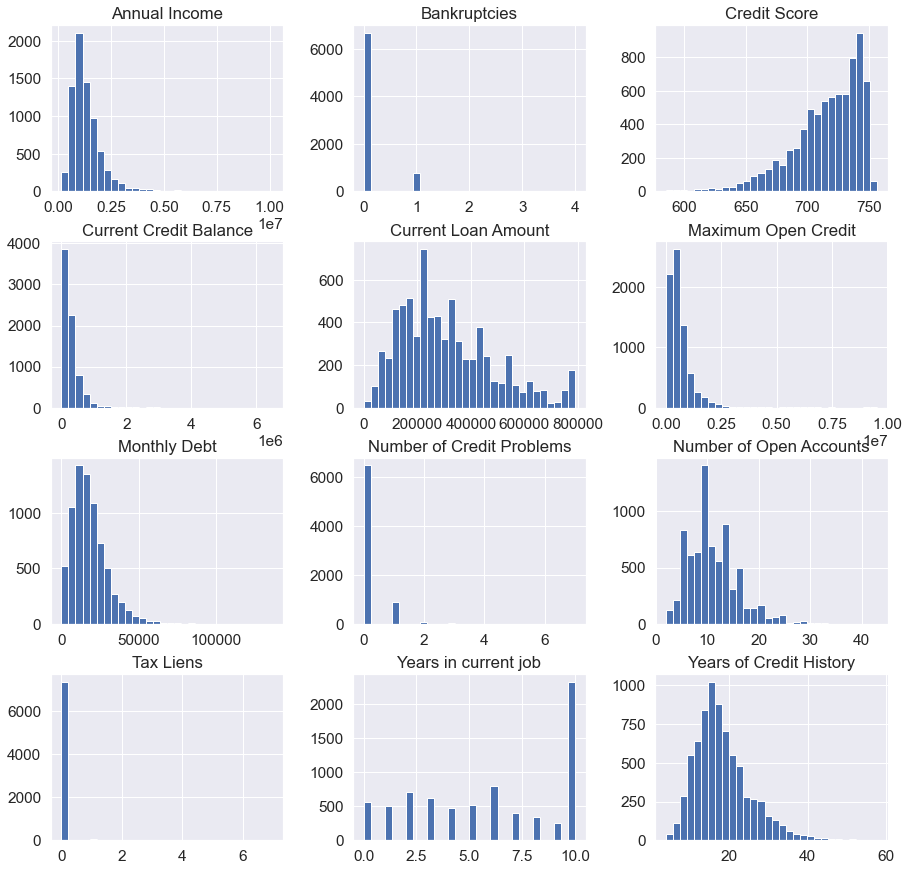

In [680]:
numeric_features = X_train.select_dtypes(exclude='object')
numeric_features = pd.DataFrame(numeric_features)
numeric_features.hist(figsize=(15, 15), bins = 30)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd3846a2080>,
      dtype=object)

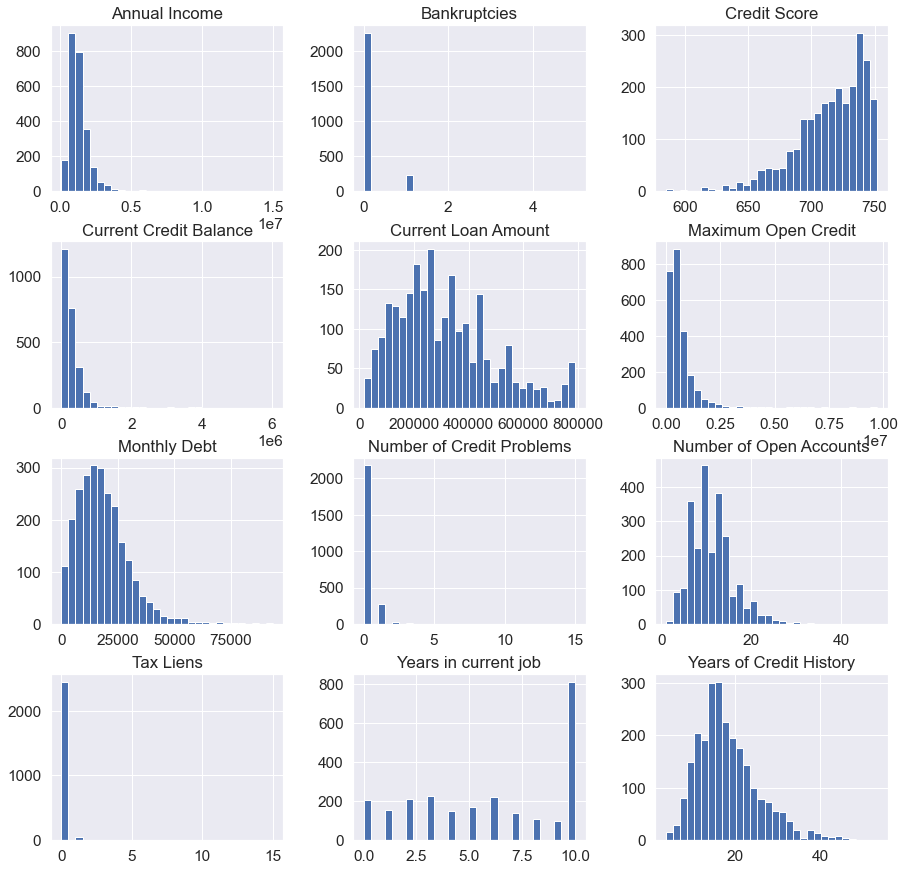

In [681]:
numeric_features = X_test.select_dtypes(exclude='object')
numeric_features = pd.DataFrame(numeric_features)
numeric_features.hist(figsize=(15, 15), bins = 30)

На данном этапе также можно было бы произвести генерацию новых признаков, однако существующие признаки довольно очевидны, и хорошо очищены, новые признаки существенного вклада не дадут.

# 4 Построение классификатора

In [682]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [683]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
      
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.axhline(0.5, color="red")
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=0.5)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [684]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_train, y_train, shuffle=True, test_size=0.25, random_state=42)
print(list(X_train_t.columns[X_train_t.dtypes==object]))
valid_model = catb.CatBoostClassifier( class_weights=[1,2.6],
                                     cat_features = ['Home Ownership', 'Purpose', 'Term'],
                                     l2_leaf_reg = 3,
                                     n_estimators=300, 
                                     max_depth=5, 
                                     silent=True, 
                                     random_state=42)
valid_model.fit(X_train_t, y_train_t)

y_train_pred = valid_model.predict(X_train_t)
y_test_pred = valid_model.predict(X_test_t)
y_test_pred_probs = valid_model.predict_proba(X_test_t)

get_classification_report(y_train_t, y_train_pred, y_test_t, y_test_pred)

[]
TRAIN

              precision    recall  f1-score   support

           0       0.84      0.70      0.76      4074
           1       0.45      0.65      0.54      1551

    accuracy                           0.69      5625
   macro avg       0.65      0.68      0.65      5625
weighted avg       0.73      0.69      0.70      5625

TEST

              precision    recall  f1-score   support

           0       0.78      0.65      0.71      1313
           1       0.41      0.56      0.47       562

    accuracy                           0.62      1875
   macro avg       0.59      0.61      0.59      1875
weighted avg       0.67      0.62      0.64      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               854  459
1               245  317


Лучший результат был достигнут при данных гиперпараметрах.
Теперь определим порог.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


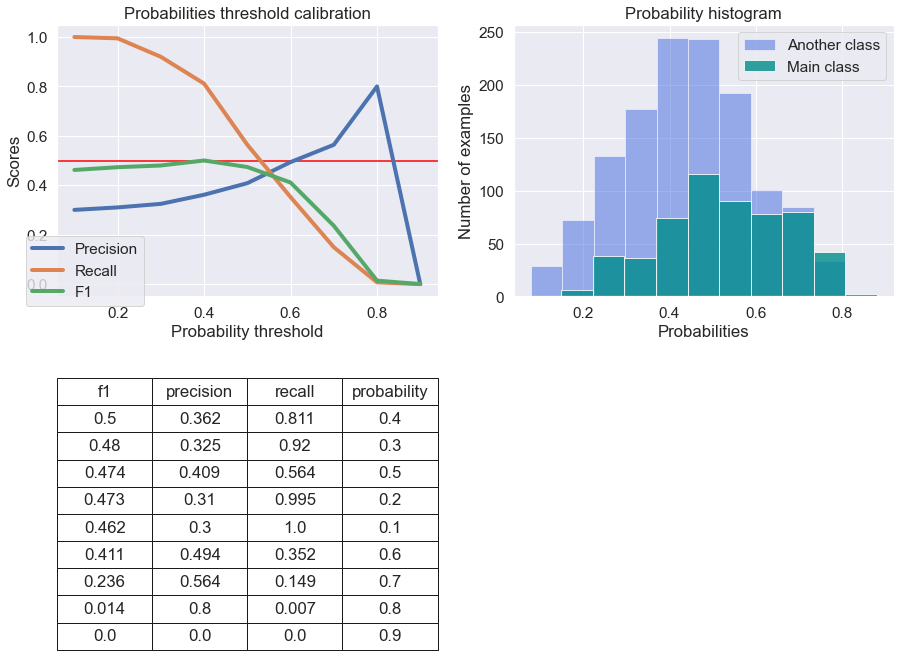

In [685]:
show_proba_calibration_plots(y_test_pred_probs[:,1], y_test_t)

In [686]:
y_p = np.array(y_test_pred_probs[:,1]>0.55).astype('int')
get_classification_report(y_train_t,y_train_pred,y_test_t,y_p)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.70      0.76      4074
           1       0.45      0.65      0.54      1551

    accuracy                           0.69      5625
   macro avg       0.65      0.68      0.65      5625
weighted avg       0.73      0.69      0.70      5625

TEST

              precision    recall  f1-score   support

           0       0.75      0.76      0.76      1313
           1       0.43      0.41      0.42       562

    accuracy                           0.66      1875
   macro avg       0.59      0.59      0.59      1875
weighted avg       0.66      0.66      0.66      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1002  311
1                329  233


С изменением порога предсказания по классам улучшились.

In [687]:
final_model = catb.CatBoostClassifier(class_weights=[1,2.6],
                                     cat_features = ['Home Ownership', 'Purpose', 'Term'],
                                     l2_leaf_reg = 3,
                                     n_estimators=300, 
                                     max_depth=5, 
                                     silent=True, 
                                     random_state=42)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.84      0.64      0.73      5387
           1       0.43      0.69      0.53      2113

    accuracy                           0.66      7500
   macro avg       0.63      0.66      0.63      7500
weighted avg       0.72      0.66      0.67      7500



In [688]:
pd.Series(y_test_pred).to_csv('IFrolkin_solution.csv',index=None)